<h1 style="text-align:center; font-size:38px; font-weight:bold; margin-top:30px;">
Topps Now NBA Print Run Prediction Model
</h1>

<h3 style="text-align:center; color:#555; margin-top:-5px;">
Sports Card Analytics • Python • Random Forest • Feature Engineering
</h3>

<hr>


## 1. Imports & Configuration

Load core Python libraries and set global options for tables and charts.


In [24]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", 50)


## 2. Load Topps Now NBA Dataset

Read the Excel file exported from my working tracker and inspect the raw structure.


In [25]:
## Excel File

DATA_PATH = r"C:\Users\Jeff\OneDrive\Professional\Topps Now NBA Project\Topps Now NBA.xlsx"
SHEET_NAME = "Sheet1"

def load_raw_data(path: str = DATA_PATH, sheet_name: str = SHEET_NAME) -> pd.DataFrame:
    """Load raw Topps Now NBA data from Excel."""
    return pd.read_excel(path, sheet_name=sheet_name)

tnnba = load_raw_data()
tnnba.head()


,Date,CardNum,Player,Team,Status,Print Run,Description,Back Image,SP,Green/99,Gold/50,Orange/25,Black/10,Red/5,FoilFractor/1,Auto_Relic,Additional Details
0,2025-10-21,1,Shai Gilgeous-Alexander,Oklahoma City Thunder,Vet,7695,MVP's 35 Points Power 2OT Opening Night Win,n,x,x,x,x,x,x,x,NaN,NaN
1,2025-10-21,2,Oklahoma City Thunder,Oklahoma City Thunder,Vet,4033,Raise 1st NBA Championship Banner IN OKC Ahead...,y,NaN,x,x,x,x,x,x,NaN,NaN
2,2025-10-21,3,Kevin Durant,Houston Rockets,Vet,1673,Vintage Form In Rockets Debut With 23-Point Game,n,NaN,x,x,x,x,x,x,NaN,NaN
3,2025-10-21,4,Alperen Sengun,Houston Rockets,Vet,1135,1st Player In NBA History With 35/5/5/5 Line I...,n,NaN,x,x,x,x,x,x,NaN,NaN
4,2025-10-21,5,Luka Doncic,Los Angeles Lakers,Vet,7591,Joins Lakers Royalty With 43 Pts In 1st LA Opener,n,NaN,x,x,x,x,x,x,NaN,NaN


## 3. Clean & Normalize Print Run Values

Standardize the `Print Run` column by removing commas, trimming spaces, and
converting placeholders (blank, 'NA', 'None', etc.) into numeric-friendly values.


In [26]:
## Clean

def clean_print_run(df: pd.DataFrame, col: str = "Print Run") -> pd.DataFrame:
    """
    Standardize the Print Run column:
    - strip spaces,
    - remove commas,
    - treat common placeholders as missing,
    - convert to numeric.
    """
    # normalize to string, remove commas, trim
    series = (
        df[col]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.strip()
    )

    # Map placeholders / text to NaN
    placeholders = {
        "": np.nan,
        "NA": np.nan,
        "NaN": np.nan,
        "nan": np.nan,
        "None": np.nan,
        "none": np.nan,
        "blank": np.nan,
        "BLANK": np.nan,
    }
    series = series.replace(placeholders)

    # final numeric conversion
    df[col] = pd.to_numeric(series, errors="coerce")
    return df

tnnba = clean_print_run(tnnba)

# Sanity check
print(tnnba["Print Run"].dtype)
tnnba["Print Run"].head(10)


float64


0     7695.0
1     4033.0
2     1673.0
3     1135.0
4     7591.0
5    43182.0
6     6491.0
7     7178.0
8     2453.0
9     2103.0
Name: Print Run, dtype: float64

## 4. Data Quality Validation

Before modeling, validate basic data health: types, missing values, duplicates,
key columns, and high-level distributions.


In [27]:
## Check data types

tnnba.dtypes


Date                  datetime64[ns]
CardNum                        int64
Player                        object
Team                          object
Status                        object
Print Run                    float64
Description                   object
Back Image                    object
SP                            object
Green/99                      object
Gold/50                       object
Orange/25                     object
Black/10                      object
Red/5                         object
FoilFractor/1                 object
Auto_Relic                    object
Additional Details            object
dtype: object

In [28]:
## Count missing values per column

tnnba.isnull().sum()


Date                   0
CardNum                0
Player                 0
Team                   0
Status                 0
Print Run              8
Description            0
Back Image             0
SP                    71
Green/99              22
Gold/50                0
Orange/25              0
Black/10               0
Red/5                  0
FoilFractor/1          0
Auto_Relic            66
Additional Details    72
dtype: int64

In [29]:
## Check for duplicate rows

tnnba.duplicated().sum()


np.int64(0)

In [30]:
## Validate CardNum is unique (assumes one record per card)

tnnba['CardNum'].is_unique


True

In [31]:
## Basic summary stats (including object columns)

tnnba.describe(include='all')


,Date,CardNum,Player,Team,Status,Print Run,Description,Back Image,SP,Green/99,Gold/50,Orange/25,Black/10,Red/5,FoilFractor/1,Auto_Relic,Additional Details
count,77,77.000000,77,77,77,69.000000,77,77,6,55,77,77,77,77,77,11,5
unique,NaN,NaN,46,27,2,NaN,76,2,1,1,1,1,1,1,1,3,2
top,NaN,NaN,Shai Gilgeous-Alexander,Los Angeles Lakers,Vet,NaN,2025 No. 4 Pick Makes NBA Debut,n,x,x,x,x,x,x,x,"A: 10,5,1","1: ""NBA Debut 10/22/25"" Inscription"
freq,NaN,NaN,5,9,56,NaN,2,71,6,55,77,77,77,77,77,9,4
mean,2025-11-05 23:41:17.922077952,39.000000,NaN,NaN,NaN,3544.275362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2025-10-21 00:00:00,1.000000,NaN,NaN,NaN,401.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2025-10-23 00:00:00,20.000000,NaN,NaN,NaN,673.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2025-10-31 00:00:00,39.000000,NaN,NaN,NaN,1095.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2025-11-18 00:00:00,58.000000,NaN,NaN,NaN,2706.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2025-12-07 00:00:00,77.000000,NaN,NaN,NaN,43182.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Feature Engineering

Create model-ready features based on basketball / hobby intuition:
rookie vs vet, short prints, autos and relics, superstars, multi-player cards,
and team market tiers.


In [32]:
## ============================
## Feature Engineering
## ============================

## Rookie / Vet Flags
tnnba['IsRookie'] = (tnnba['Status'] == 'RC').astype(int)
tnnba['IsVet']    = (tnnba['Status'] == 'Vet').astype(int)

## Multi-Player Card Flag
tnnba['IsMultiPlayer'] = tnnba['Player'].str.contains('/', na=False).astype(int)

## Short Prints
tnnba['SPInserts'] = tnnba['SP'].eq('x').astype(int)

## Autos and Relics
tnnba['HasAutoRelic'] = tnnba['Auto_Relic'].notna().astype(int)

## Superstars
superstars = [
    'Stephen Curry', 'LeBron James', 'Luka Doncic', 'Nikola Jokic', 
    'Giannis Antetokounmpo', 'Victor Wembanyama', 'Shai Gilgeous-Alexander'
]
tnnba['IsSuperstar'] = tnnba['Player'].apply(lambda x: any(s in x for s in superstars)).astype(int)

## Team Tiers
tier_1 = ['Los Angeles Lakers', 'Boston Celtics', 'Golden State Warriors', 'New York Knicks']
tier_2 = ['Miami Heat', 'Chicago Bulls', 'Philadelphia 76ers', 'Dallas Mavericks']
tier_3 = ['Phoenix Suns', 'San Antonio Spurs', 'Houston Rockets', 'Toronto Raptors']
tier_4 = ['Denver Nuggets', 'Milwaukee Bucks', 'Cleveland Cavaliers', 'Atlanta Hawks']
tier_5 = ['Memphis Grizzlies', 'Oklahoma City Thunder', 'Utah Jazz', 'Portland Trail Blazers']
tier_6 = ['Minnesota Timberwolves', 'Indiana Pacers', 'Washington Wizards', 'Orlando Magic']
tier_7 = ['Charlotte Hornets', 'Detroit Pistons', 'Sacramento Kings', 'Brooklyn Nets']

team_tier_map = {
    **{t: 1 for t in tier_1},
    **{t: 2 for t in tier_2},
    **{t: 3 for t in tier_3},
    **{t: 4 for t in tier_4},
    **{t: 5 for t in tier_5},
    **{t: 6 for t in tier_6},
    **{t: 7 for t in tier_7},
}

tnnba['TeamTier'] = tnnba['Team'].map(team_tier_map)


## 6. Exploratory Analysis with Engineered Features

Summarize how print runs behave across the engineered flags:
rookie vs vet, multi-player vs single, short prints, autos/relics,
superstar status, and team tiers.


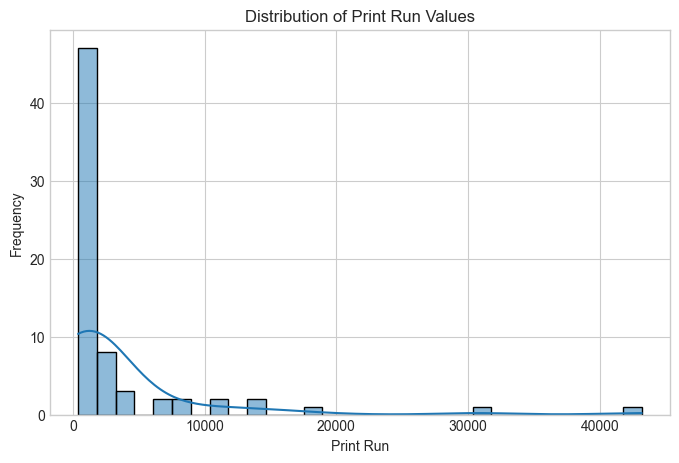

In [33]:
## Print Run Distribution

plt.figure(figsize=(8,5))
sns.histplot(tnnba["Print Run"].dropna(), bins=30, kde=True)
plt.title("Distribution of Print Run Values")
plt.xlabel("Print Run")
plt.ylabel("Frequency")
plt.show()


In [34]:
## Create IsRookie flag from Status 

if 'IsRookie' not in tnnba.columns:
    tnnba['IsRookie'] = (tnnba['Status'] == 'RC').astype(int)

tnnba[['Status', 'IsRookie']].head()


,Status,IsRookie
0,Vet,0
1,Vet,0
2,Vet,0
3,Vet,0
4,Vet,0


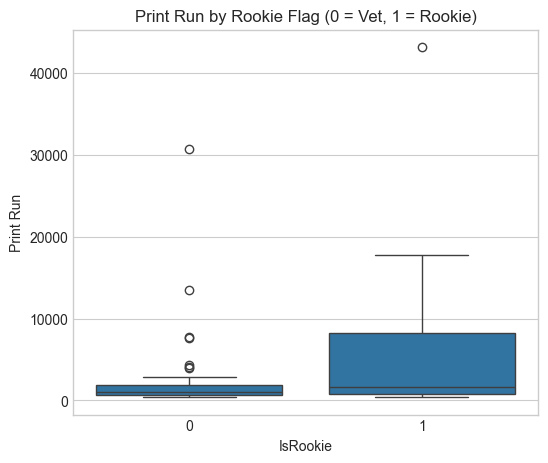

In [35]:
## Print Runs Rookie vs Vet

plt.figure(figsize=(6,5))
sns.boxplot(data=tnnba, x="IsRookie", y="Print Run")
plt.title("Print Run by Rookie Flag (0 = Vet, 1 = Rookie)")
plt.xlabel("IsRookie")
plt.ylabel("Print Run")
plt.show()


In [36]:
## Create Short Print flag (SPInserts) if it doesn't exist

if 'SPInserts' not in tnnba.columns:
    tnnba['SPInserts'] = (tnnba['SP'] == 'x').astype(int)

tnnba[['SP', 'SPInserts']].head()


,SP,SPInserts
0,x,1
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0


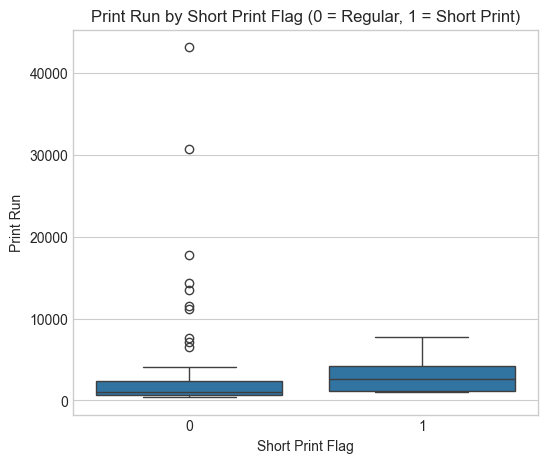

In [37]:
## Short Print vs Regular Print Runs

plt.figure(figsize=(6,5))
sns.boxplot(data=tnnba, x="SPInserts", y="Print Run")
plt.title("Print Run by Short Print Flag (0 = Regular, 1 = Short Print)")
plt.xlabel("Short Print Flag")
plt.ylabel("Print Run")
plt.show()



array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'CardNum'}>,
        <Axes: title={'center': 'Print Run'}>],
       [<Axes: title={'center': 'IsRookie'}>,
        <Axes: title={'center': 'IsVet'}>,
        <Axes: title={'center': 'IsMultiPlayer'}>],
       [<Axes: title={'center': 'SPInserts'}>,
        <Axes: title={'center': 'HasAutoRelic'}>,
        <Axes: title={'center': 'IsSuperstar'}>],
       [<Axes: title={'center': 'TeamTier'}>, <Axes: >, <Axes: >]],
      dtype=object)

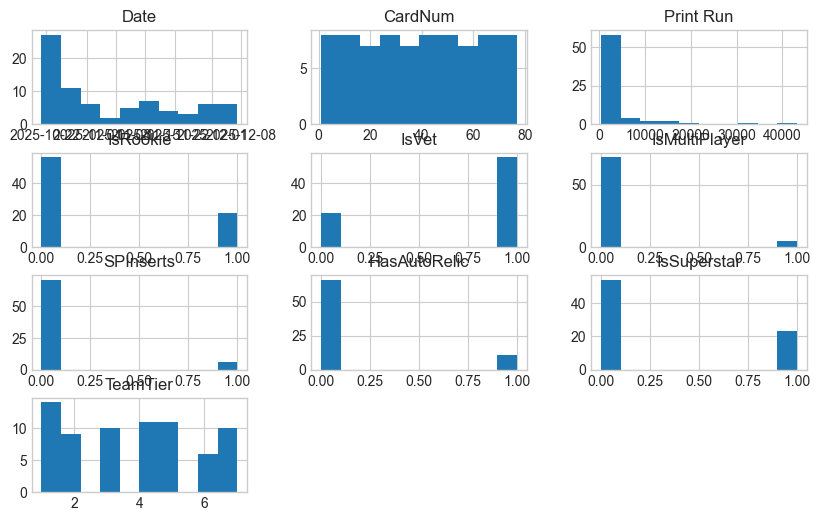

In [38]:
## Visual Sanity Check via Histogram

tnnba.hist(figsize=(10,6))

In [39]:
## Rookie vs Vet Comparison

rookie_summary = (
    tnnba.groupby('IsRookie', as_index=False)
         .agg(
             avg_print_run   = ('Print Run', 'mean'),
             median_print_run= ('Print Run', 'median'),
             num_cards       = ('Print Run', 'count')
         )
)

rookie_summary['group'] = rookie_summary['IsRookie'].map({0: 'Vet', 1: 'Rookie'})
rookie_summary


,IsRookie,avg_print_run,median_print_run,num_cards,group
0,0,2410.408163,1063.0,49,Vet
1,1,6322.250000,1608.0,20,Rookie


In [40]:
## Autos & Relics vs Standard Cards

auto_summary = (
    tnnba.groupby('HasAutoRelic', as_index=False)
         .agg(
             avg_print_run    = ('Print Run', 'mean'),
             median_print_run = ('Print Run', 'median'),
             num_cards        = ('Print Run', 'count')
         )
)

auto_summary['group'] = auto_summary['HasAutoRelic'].map({0: 'No Auto/Relic', 1: 'Has Auto/Relic'})
auto_summary


,HasAutoRelic,avg_print_run,median_print_run,num_cards,group
0,0,2281.152542,1042.0,59,No Auto/Relic
1,1,10996.700000,4598.5,10,Has Auto/Relic


In [41]:
## Superstars

superstar_summary = (
    tnnba.groupby('IsSuperstar', as_index=False)
         .agg(
             avg_print_run=('Print Run','mean'),
             median_print_run=('Print Run','median'),
             num_cards=('Print Run','count')
         )
)

superstar_summary['group'] = superstar_summary['IsSuperstar'].map({0: 'Non-Superstar', 1: 'Superstar'})
superstar_summary


,IsSuperstar,avg_print_run,median_print_run,num_cards,group
0,0,3254.595745,898.0,47,Non-Superstar
1,1,4163.136364,1657.0,22,Superstar


In [42]:
## Teams

team_summary = (
    tnnba.groupby('TeamTier', as_index=False)
         .agg(
             avg_print_run=('Print Run','mean'),
             median_print_run=('Print Run','median'),
             num_cards=('Print Run','count')
         )
)
team_summary


,TeamTier,avg_print_run,median_print_run,num_cards
0,1.0,5369.272727,2789.0,11
1,2.0,11561.222222,11225.0,9
2,3.0,3236.111111,1673.0,9
3,4.0,891.200000,944.0,10
4,5.0,1936.272727,1095.0,11
5,6.0,863.200000,997.0,5
6,7.0,871.800000,687.0,10


## 7. Build Modeling Dataset

Filter to rows with a known print run, apply a log transform to the target,
and assemble the final feature matrix used for prediction.


In [43]:
## Start from your fully engineered dataframe
model_df = tnnba.copy()

## Make sure Print Run is numeric
model_df['PrintRun'] = pd.to_numeric(model_df['Print Run'], errors='coerce')

## Only keep rows with a valid print run
model_df = model_df[model_df['PrintRun'].notna()].copy()

## Log-transform target
model_df['LogPrintRun'] = np.log1p(model_df['PrintRun'])

## Final feature list
feature_cols = [
    'IsRookie',
    'SPInserts',
    'HasAutoRelic',
    'IsSuperstar',
    'TeamTier',
    'IsMultiPlayer'
]

target_col = 'LogPrintRun'

## Keep only the columns we care about
model_df = model_df[feature_cols + [target_col]].copy()

## Handle missing feature values (e.g., teams not in mapping)
model_df[feature_cols] = model_df[feature_cols].fillna(0)

## Make sure everything is numeric
for col in feature_cols + [target_col]:
    model_df[col] = pd.to_numeric(model_df[col], errors='coerce')

## Drop any remaining rows with NaN in X or y
model_df = model_df.dropna(subset=feature_cols + [target_col])

## Build X and y
X = model_df[feature_cols].astype(float)
y = model_df[target_col].astype(float)

print("Rows in modeling dataset:", len(model_df))
print("Total NaNs in X:", X.isna().sum().sum())
print("Total NaNs in y:", y.isna().sum())



Rows in modeling dataset: 69
Total NaNs in X: 0
Total NaNs in y: 0


## 8. Train Random Forest Model

Split the data into training and test sets, fit a Random Forest Regressor,
and evaluate performance on the held-out test set.


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

## Predictions
y_pred = rf_model.predict(X_test)

## Metrics
log_mae = mean_absolute_error(y_test, y_pred)
log_mse = mean_squared_error(y_test, y_pred)
log_rmse = np.sqrt(log_mse)
r2 = r2_score(y_test, y_pred)

print(f"Log MAE:  {log_mae:.3f}")
print(f"Log RMSE: {log_rmse:.3f}")
print(f"R²:       {r2:.3f}")



Log MAE:  0.742
Log RMSE: 0.980
R²:       0.587


## 9. Model Run Checks

Visual diagnostics showing how well the model fits and which features drive
the predictions.


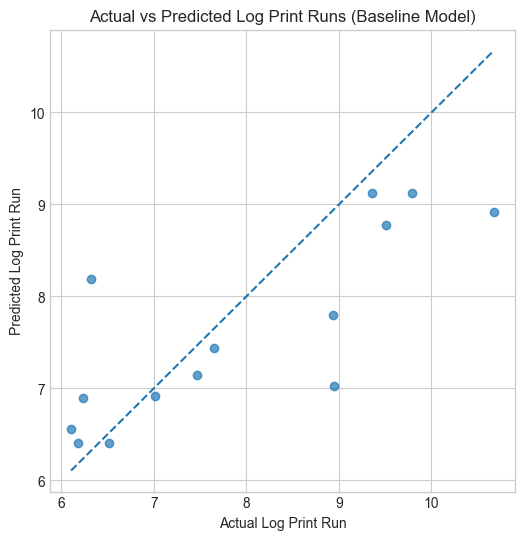

In [45]:
## PLot Actual vs Predicted (log scale)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Actual Log Print Run')
plt.ylabel('Predicted Log Print Run')
plt.title('Actual vs Predicted Log Print Runs (Baseline Model)')
plt.show()


In [46]:
## Check Feature Importance

importances = rf_model.feature_importances_
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

fi



,feature,importance
4,TeamTier,0.439504
2,HasAutoRelic,0.232494
3,IsSuperstar,0.152513
0,IsRookie,0.135780
5,IsMultiPlayer,0.021044
1,SPInserts,0.018666


## 10. Insights & Next Steps

- Current R² is approximately **0.587** on the log-transformed target.  
  This means the model currently explains ~59% of the variation in print runs.
- `TeamTier` and `HasAutoRelic` emerge as strong drivers of print run.
- Rookie status and superstar flag provide additional lift, especially for
  high-visibility markets and breakout games.

**Next iterations:**

- Add more seasons of Topps Now NBA data as they release.
- Incorporate game performance stats (e.g., points, triple doubles).
- Experiment with gradient boosting (XGBoost / LightGBM).
- Build a Power BI dashboard that compares actual vs predicted print runs
  across teams, players, and release windows.


In [47]:
## Save the model for later use
import joblib
joblib.dump(rf_model, 'topps_nba_baseline_model.joblib')



['topps_nba_baseline_model.joblib']

In [49]:
## Prepare Dataset for Power BI: Export Columns
export_cols = [
    'Date', 'CardNum', 'Player', 'Team', 'Status', 'Print Run',
    'IsRookie', 'IsMultiPlayer', 'SPInserts', 'HasAutoRelic',
    'IsSuperstar', 'TeamTier'
]

tnnba_export = tnnba[export_cols]


In [50]:
## Prepare Dataset for Power BI: Export to CSV
tnnba_export.to_csv(r"C:\Users\Jeff\OneDrive\Professional\Topps Now NBA Project\topps_nba_clean.csv", index=False)
print("Export Complete")

Export Complete
